In [1]:
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('ncaa_mens_scores_2024.csv')

In [3]:
ncaaAvgHomeGoals = df['home_team_score'].mean()
ncaaAvgAwayGoals = df['away_team_score'].mean()

In [4]:
# Cap goal differences at a maximum of 5 goals
df['capped_home_team_score'] = df.apply(
    lambda row: min(row['home_team_score'], row['away_team_score'] + 5), axis=1
)
df['capped_away_team_score'] = df.apply(
    lambda row: min(row['away_team_score'], row['home_team_score'] + 5), axis=1
)

# Create home df
teams = df[df['home_team_conference'] != 'Not D1'][['home_team', 'home_team_conference']].drop_duplicates()
home_df = teams
home_df.columns = ['Team', 'Conference']

# Initialize home df columns using capped scores
home_df['MP'] = home_df['Team'].apply(lambda team: len(df[df['home_team'] == team]))
home_df['GF'] = home_df['Team'].apply(lambda team: df[df['home_team'] == team]['capped_home_team_score'].sum())
home_df['GA'] = home_df['Team'].apply(lambda team: df[df['home_team'] == team]['capped_away_team_score'].sum())

home_df['ATT'] = home_df.apply(
    lambda row: ((row['GF'] / row['MP']) / ncaaAvgHomeGoals) * 
                (df[df['home_team_conference'] == row['Conference']]['capped_home_team_score'].mean() / ncaaAvgHomeGoals),
    axis=1
)

home_df['DEF'] = home_df.apply(
    lambda row: ((row['GA'] / row['MP']) / ncaaAvgAwayGoals) * 
                (df[df['home_team_conference'] == row['Conference']]['capped_away_team_score'].mean() / ncaaAvgAwayGoals),
    axis=1
)

# Create away df
teams_away = df[df['away_team_conference'] != 'Not D1'][['away_team', 'away_team_conference']].drop_duplicates()
away_df = teams_away
away_df.columns = ['Team', 'Conference']

# Initialize away df columns using capped scores
away_df['MP'] = away_df['Team'].apply(lambda team: len(df[df['away_team'] == team]))
away_df['GF'] = away_df['Team'].apply(lambda team: df[df['away_team'] == team]['capped_away_team_score'].sum())
away_df['GA'] = away_df['Team'].apply(lambda team: df[df['away_team'] == team]['capped_home_team_score'].sum())

away_df['ATT'] = away_df.apply(
    lambda row: ((row['GF'] / row['MP']) / ncaaAvgAwayGoals) * 
                (df[df['away_team_conference'] == row['Conference']]['capped_away_team_score'].mean() / ncaaAvgAwayGoals),
    axis=1
)

away_df['DEF'] = away_df.apply(
    lambda row: ((row['GA'] / row['MP']) / ncaaAvgHomeGoals) * 
                (df[df['away_team_conference'] == row['Conference']]['capped_home_team_score'].mean() / ncaaAvgHomeGoals),
    axis=1
)


In [5]:
# Calculate expected scoreline
def calculateExpectedScoreline(home, away):
    # Check if the teams exist in the dataframes
    if home not in home_df['Team'].values or away not in away_df['Team'].values:
        raise ValueError(f"One or both teams ({home}, {away}) not found in the data.")

    # Get the rows for the respective teams
    home_row = home_df[home_df['Team'] == home]
    away_row = away_df[away_df['Team'] == away]
    
    # Extract attack and defense ratings
    home_att = home_row['ATT'].values[0]
    home_def = home_row['DEF'].values[0]
    away_att = away_row['ATT'].values[0]
    away_def = away_row['DEF'].values[0]
    
    # Calculate expected goals for both teams
    home_xG = home_att * away_def * ncaaAvgHomeGoals
    away_xG = away_att * home_def * ncaaAvgAwayGoals
    
    return [home_xG, away_xG]

# Calculate match probabilities
def calculateMatchProbability(home, away, max_goals=10):
    # Get expected goals for the match
    try:
        home_xG, away_xG = calculateExpectedScoreline(home, away)
    except ValueError as e:
        return str(e)

    # Initialize cumulative probabilities
    home_win_prob = 0
    draw_prob = 0
    away_win_prob = 0

    # Iterate through possible scores to compute probabilities
    for home_goals in range(max_goals):
        for away_goals in range(max_goals):
            # Calculate Poisson probabilities for each team
            home_prob = poisson.pmf(home_goals, home_xG)
            away_prob = poisson.pmf(away_goals, away_xG)
            
            # Joint probability of this specific scoreline
            match_prob = home_prob * away_prob
            
            # Update cumulative probabilities based on the result
            if home_goals > away_goals:
                home_win_prob += match_prob
            elif home_goals == away_goals:
                draw_prob += match_prob
            else:
                away_win_prob += match_prob
    
    # Return probabilities as a dictionary for clarity
    return {
        'Home Win Probability': home_win_prob,
        'Draw Probability': draw_prob,
        'Away Win Probability': away_win_prob
    }


In [6]:
#home_df.to_csv(rf'home_df.csv', index=False)
#away_df.to_csv(rf'away_df.csv', index=False)

In [7]:
# Merge home_df and away_df on 'Team' and 'Conference'
overall_df = pd.merge(home_df, away_df, on=['Team', 'Conference'], how='inner')

# Metrics to combine
metrics = ['MP', 'GF', 'GA', 'ATT', 'DEF']

# Combine _x and _y metrics
for metric in metrics:
    overall_df[metric] = overall_df[f'{metric}_x'] + overall_df[f'{metric}_y']

# Drop original _x and _y columns
columns_to_drop = [f'{metric}_x' for metric in metrics] + [f'{metric}_y' for metric in metrics]
overall_df = overall_df.drop(columns=columns_to_drop)

# Average ATT and DEF metrics
overall_df['ATT'] = overall_df['ATT'] / 2
overall_df['DEF'] = overall_df['DEF'] / 2

# Create 'STR' column (normalized strength by conference)
overall_df['STR'] = (overall_df['ATT']*0.5 + (1 / overall_df['DEF'])*0.5)

In [8]:
overall_df['MAX'] = (overall_df['STR'] - overall_df['STR'].min()) / (overall_df['STR'].max() - overall_df['STR'].min())*100

In [9]:
import random
from collections import defaultdict
from tqdm import tqdm

# Set simulation parameters
N_SIMULATIONS = 10
MAX_GOALS = 10

# Filter for Big Ten teams
conference = "Big South"
teams = overall_df[overall_df['Conference'] == conference]['Team'].tolist()
n_teams = len(teams)

# Initialize win counter
win_counts = {team: 0 for team in teams}

# Run simulations
for _ in tqdm(range(N_SIMULATIONS), desc=f"Simulating {conference}"):
    sim_results = defaultdict(int)

    # Simulate round-robin matchups
    for i in range(n_teams):
        for j in range(i + 1, n_teams):
            team1 = teams[i]
            team2 = teams[j]

            # Simulate match outcome
            probs = calculateMatchProbability(team1, team2, max_goals=MAX_GOALS)
            outcome = random.choices(
                population=['team1', 'draw', 'team2'],
                weights=[
                    probs['Home Win Probability'],
                    probs['Draw Probability'],
                    probs['Away Win Probability']
                ]
            )[0]

            # Assign points
            if outcome == 'team1':
                sim_results[team1] += 3
            elif outcome == 'team2':
                sim_results[team2] += 3
            else:
                sim_results[team1] += 1
                sim_results[team2] += 1

    # Rank and assign weighted scores
    sorted_teams = sorted(sim_results.items(), key=lambda x: x[1], reverse=True)
    for team, points in sim_results.items():
        win_counts[team] += points


# Normalize and sort results
avg_rankings = {team: win_counts[team] / N_SIMULATIONS for team in win_counts}
sorted_avg = sorted(avg_rankings.items(), key=lambda x: x[1], reverse=True)

# Display results
for team, score in sorted_avg:
    print(f"{team:<30} {score:.2f}")


Simulating Big South: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]

High Point                     17.60
Gardner-Webb                   14.40
UNC Asheville                  12.70
Presbyterian                   11.40
Longwood                       7.20
Winthrop                       5.70
Radford                        5.60
USC Upstate                    5.10


In [16]:
overall_df.sort_values(by="MAX", ascending=False)

,Team,Conference,MP,GF,GA,ATT,DEF,STR,MAX
67,Ohio St.,Big Ten,22,51,19,1.974281,0.588946,1.836115,100.000000
196,Vermont,America East,24,48,19,1.386663,0.448323,1.808600,97.995056
209,Denver,Summit League,23,44,18,1.533825,0.523512,1.722001,91.684788
71,Pittsburgh,ACC,20,38,18,1.579608,0.539377,1.716799,91.305755
97,Charlotte,The American,19,27,16,0.904612,0.397145,1.711293,90.904562
...,...,...,...,...,...,...,...,...,...
197,Radford,Big South,16,12,37,0.553861,1.908074,0.538975,5.480541
208,Southern Ind.,OVC,18,10,42,0.357010,1.547646,0.501576,2.755406
19,Eastern Ill.,OVC,16,12,43,0.467834,1.927179,0.493364,2.156946
150,Air Force,WAC,17,11,44,0.419111,1.814052,0.485181,1.560742


In [26]:
overall_df["Conference"].unique()

array(['SoCon', 'Atlantic 10', 'CAA', 'Patriot', 'Big East', 'NEC',
       'Horizon', 'Summit League', 'ACC', 'Sun Belt', 'MAAC', 'MVC',
       'America East', 'OVC', 'The American', 'Big Ten', 'AAC', 'ASUN',
       'Big West', 'WCC', 'WAC', 'Big South', 'Ivy League'], dtype=object)

In [21]:
# Simulate Big Ten rankings
N_SIMULATIONS = 10000
MAX_GOALS = 8
conference = "America East"
teams = overall_df[overall_df['Conference'] == conference]['Team'].tolist()
n_teams = len(teams)
rank_counts = {team: [0] * n_teams for team in teams}

for _ in tqdm(range(N_SIMULATIONS)):
    sim_results = defaultdict(int)
    for i in range(n_teams):
        for j in range(i+1, n_teams):
            team1 = teams[i]
            team2 = teams[j]
            probs = calculateMatchProbability(team1, team2, max_goals=MAX_GOALS)
            outcome = random.choices(
                population=['team1', 'draw', 'team2'],
                weights=[probs['Home Win Probability'], probs['Draw Probability'], probs['Away Win Probability']]
            )[0]
            if outcome == 'team1':
                sim_results[team1] += 3
            elif outcome == 'team2':
                sim_results[team2] += 3
            else:
                sim_results[team1] += 1
                sim_results[team2] += 1
    sorted_teams = sorted(sim_results.items(), key=lambda x: x[1], reverse=True)
    for rank, (team, _) in enumerate(sorted_teams):
        rank_counts[team][rank] += 1

# Convert rank counts to percentage table
def ordinal(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

rank_df = pd.DataFrame(rank_counts).T
rank_df.columns = [ordinal(i + 1) for i in range(n_teams)]
rank_df = rank_df.applymap(lambda x: round(100 * x / N_SIMULATIONS, 2))
rank_df.index.name = "Team"

100%|██████████| 10000/10000 [33:33<00:00,  4.97it/s]
C:\Users\maxwe\AppData\Local\Temp\ipykernel_30788\892021275.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rank_df = rank_df.applymap(lambda x: round(100 * x / N_SIMULATIONS, 2))


In [19]:
overall_df[overall_df['Conference'] == conference].sort_values(by='MAX', ascending=False)

,Team,Conference,MP,GF,GA,ATT,DEF,STR,MAX
196,Vermont,America East,24,48,19,1.386663,0.448323,1.808600,97.995056
124,Bryant,America East,20,29,13,1.030037,0.427825,1.683720,88.895361
113,New Hampshire,America East,17,23,13,0.963959,0.492742,1.496710,75.268409
52,UMBC,America East,19,28,23,1.015391,0.740160,1.183225,52.425501
18,UMass Lowell,America East,16,21,22,0.993573,0.785868,1.133025,48.767561
104,Binghamton,America East,19,23,28,0.919015,0.821204,1.068369,44.056247
59,NJIT,America East,18,23,26,0.794232,0.806213,1.017299,40.334865
107,UAlbany,America East,18,21,39,0.876016,1.435086,0.786419,23.511202


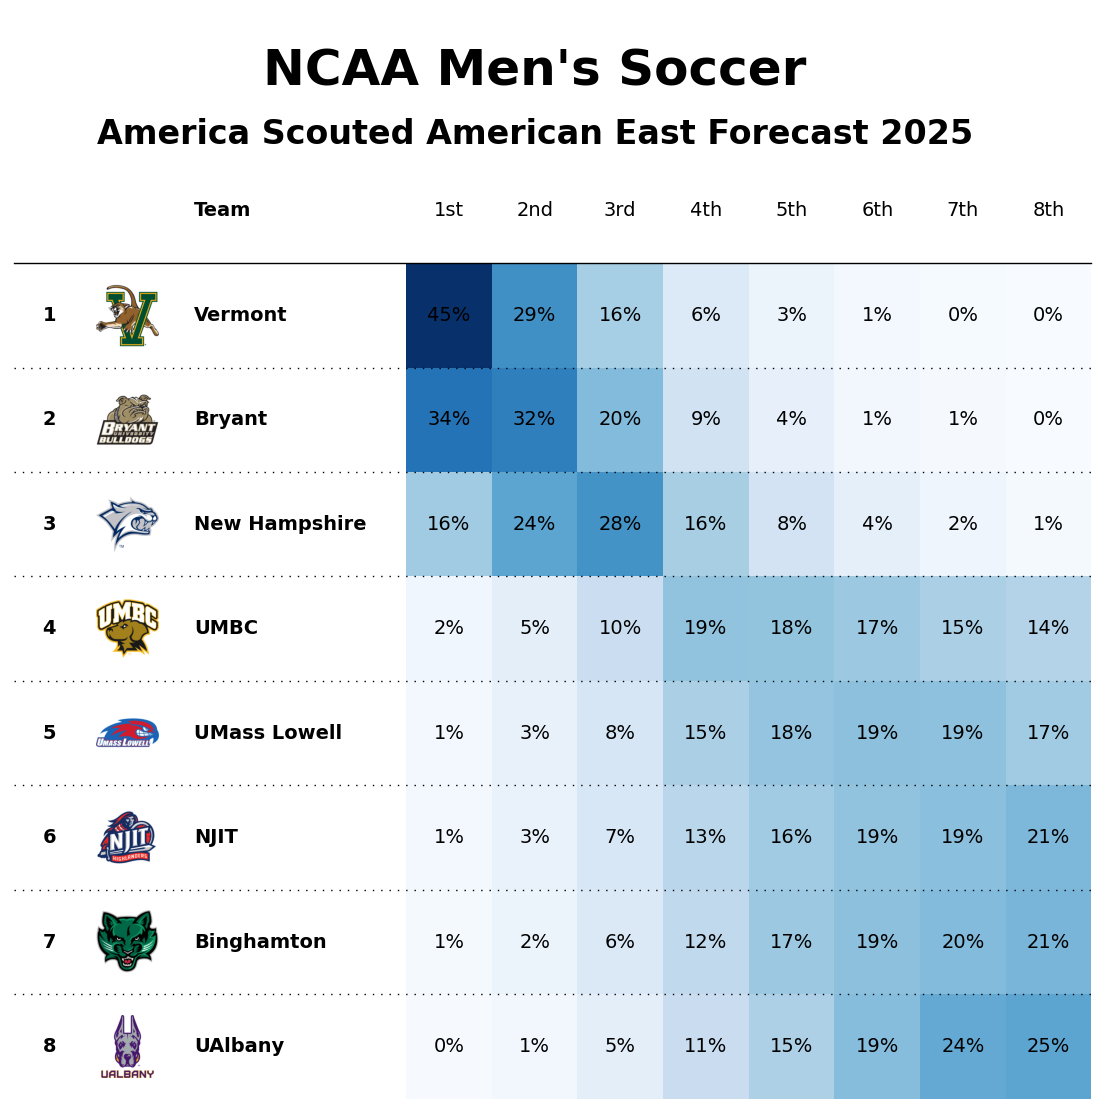

In [25]:
from plottable import ColumnDefinition, Table
from plottable.plots import image
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

# -----------------------------
# STEP 0: Copy and turn the index into a "Team" column
# -----------------------------
df = rank_df.copy().reset_index().rename(columns={'index': 'Team'})

# -----------------------------
# STEP 1: Add logo paths
# -----------------------------
df["Badge"] = df["Team"].apply(
    lambda x: f"C:/Users/maxwe/OneDrive - The Pennsylvania State University/Statlink/Logos_png/{x}.png"
)

# -----------------------------
# STEP 2: Calculate average finish
# -----------------------------
ordinal_cols = [c for c in df.columns if c.endswith(('st','nd','rd','th'))]

def extract_ordinal_number(col):
    return int(col.rstrip('stndrh'))

weights = [extract_ordinal_number(c) for c in ordinal_cols]

df['AverageFinish'] = df[ordinal_cols].multiply(weights).sum(axis=1) / 100
df = df.sort_values("AverageFinish").drop(columns="AverageFinish").reset_index(drop=True)
df['Rank'] = df.index + 1
df = df.set_index("Rank")
df = df[['Badge','Team'] + ordinal_cols]

# -----------------------------
# STEP 3: Helpers for coloring & formatting
# -----------------------------
# percentage formatter
def pct(v):
    return f"{int(round(v))}%"

# build a linear mapping from [0, vmax] → Blues[0..1]
def linear_cmap(values, cmap, vmin, vmax):
    norm = Normalize(vmin=vmin, vmax=vmax)
    return lambda x: cmap(norm(x))

# compute one common maximum across all ordinal columns
global_max = df[ordinal_cols].to_numpy().max()

# -----------------------------
# STEP 4: Build ColumnDefinitions
# -----------------------------
col_defs = [
    ColumnDefinition(
        name="Rank", title="", textprops={"ha":"center","weight":"bold"}, width=0.5
    ),
    ColumnDefinition(
        name="Badge", title="", width=0.6, plot_fn=image
    ),
    ColumnDefinition(
        name="Team", title="Team", textprops={"ha":"left","weight":"bold"}, width=1.65
    ),
]

for pos in ordinal_cols:
    col_defs.append(
        ColumnDefinition(
            name=pos,
            title=pos,
            width=0.6,
            textprops={"ha":"center"},
            cmap=linear_cmap(df[pos], matplotlib.cm.Blues, vmin=0, vmax=global_max),
            formatter=pct,
        )
    )

# -----------------------------
# STEP 5: Plot function
# -----------------------------
def plot_finish_table(
    df,
    title="NCAA Men's Soccer",        # <-- main title
    subtitle="America Scouted American East Forecast 2025",  # <-- subtitle
    filename="Forecasts/americaneast_table.png"
):
    # create the figure + axes
    fig, ax = plt.subplots(figsize=(14, 12))

    # add the main title and subtitle
    fig.suptitle(title,
                 fontsize=36,
                 fontweight="bold",
                 y=0.99)                   # push up near top
    fig.text(0.5,
             0.91,
             subtitle,
             ha="center",
             fontweight="bold",
             fontsize=24,
             color="black")
    fig.text(0.5,
             1,
             "lol",
             ha="center",
             fontweight="bold",
             fontsize=24,
             color="white")

    # adjust the top margin so titles don't overlap table
    fig.subplots_adjust(top=0.90)

    # draw the table
    Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=False,
        ax=ax,
        textprops={"fontsize":14,"ha":"center","color":"black"},
        row_divider_kw={"linewidth":1,"linestyle":(0,(1,5))},
        col_label_divider_kw={"linewidth":1,"linestyle":"-"},
        column_border_kw={"linewidth":1,"linestyle":"-"},
    )

    # save or show
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.show()

# -----------------------------
# STEP 6: Run it
# -----------------------------
#plot_finish_table(df)